# Table of Contents
The 
* Effective Machine Learning
    * Disproportional Data sampling
    * EDA & Preprocessing
    * Model Selection and Evaluation
* Efficient Machine Learning 
    * Model performance on different scale of sampling data
    * Potential integration with IPS(Intrusion Prevention System)


# Effective Machine Learning
Below is a summary of the performance metrics for each model tested on the **validation** dataset:

| Model                           | Accuracy      | Precision     | Recall        | F1 Score     | Confusion Matrix                 |
|---------------------------------|---------------|---------------|---------------|--------------|----------------------------------|
| **Threshold Method**            | 0.98195       | 0.56579       | 0.99973       | 0.72262      | `[[894926, 16847], [6, 21952]]`  |
| **Linear Classification**       | 0.98695       | 0.69640       | 0.78942       | 0.73999      | `[[904216, 7557], [4624, 17334]]` |
| **Random Forest Classification**| 0.97957       | 0.57553       | 0.49954       | 0.53485      | `[[903683, 8090], [10989, 10969]]` |
| **Autoencoder Classification**  | 0.981951      | 0.5655        | 0.9997        | 0.7221       | `[[894925, 16848], [6, 21952]]`   |


inspired by Alexandre Le Mercier.

_________________


In [3]:
#!pip install optuna
#!pip install dataprep

In [4]:
#!pip install scikit-learn
#!pip install pandas
#!pip install seaborn
#!pip install numpy
#!pip install tensorflow==2.13.0

In [5]:
#!pip install sweetviz

In [6]:
import pandas as pd
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# import sweetviz as sv
#import dataprep as dp
#from dataprep.eda import plot, plot_correlation, create_report, plot_missing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

import pickle

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from PIL import Image
import warnings
from tqdm import tqdm, trange
import optuna

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

# for lib in [pd, sk, sns, sv, optuna, tf, keras]:
for lib in [pd, sk, sns, optuna, tf, keras]:
    print(f"Using {lib.__name__} {lib.__version__}")

RANDOM_SEED = 5
PATH_TO_QAE_CLASS = "../../Quantized Autoencoders (QAE)/Final Versions"
tf.random.set_seed(RANDOM_SEED)
"""
# Import the QAE class
sys.path.append(os.path.abspath(PATH_TO_QAE_CLASS))
from QAE import QAE
print("INFO: QAE class successfully imported.")
"""

2024-11-28 02:52:18.039648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 02:52:18.039786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 02:52:18.212265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using pandas 2.2.2
Using sklearn 1.2.2
Using seaborn 0.12.2
Using optuna 3.6.1
Using tensorflow 2.15.0
Using keras 3.4.1


'\n# Import the QAE class\nsys.path.append(os.path.abspath(PATH_TO_QAE_CLASS))\nfrom QAE import QAE\nprint("INFO: QAE class successfully imported.")\n'

## Importing Data
Since the original dataset is extremely bias so a dispropotional sampling was applied.

In [7]:
# dataset used
# replace with Zach's df
df2 = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.001_dist_percent_2classes.csv")
df8 = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.001_dist_percent_8classes.csv")
df34 = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.001_dist_percent_34classes.csv")

## EDA & Preprocessing
**Summary Table of EDA Methods and Preprocessing**
Following table is a brief summary of common Exploratory Data Analysis (EDA) and corresponding Preprocessing methods. 

| EDA Method|Typical Preprocessing/Feature Engineering|Relevancy to current probelm|
|--|--|--|
|Data Cleaning|Handle missing values, duplicates, and outliers.|outlier is the challenge of the dataset, capping techniques are applied to |
|Univariate Analysis|Normalize/encode features, transform skewed data.|show skewness of the data and visualize with histogram, boxplot, drop column with limited info|
|Multivariate Analysis|Normalize, reduce multicollinearity, apply dimensionality reduction.|show Correlation table and reduce dimension with PCA/t-CNS|
|Target Variable Analysis|Balance classes, transform skewed distributions.|the label class is highly biased , espcially for (D)DOS. Dispropotional Sampling is used to balance class |
|Time Series Analysis|Interpolate missing data, extract date/time features, apply smoothing.|N/A, since the dataset is already engineered and temporal information has been compacted|



In [8]:
one_hot_cols = ['http','https','dns','telnet','smtp','ssh','irc','tcp','udp','dhcp','arp','icmp','ipv','llc']

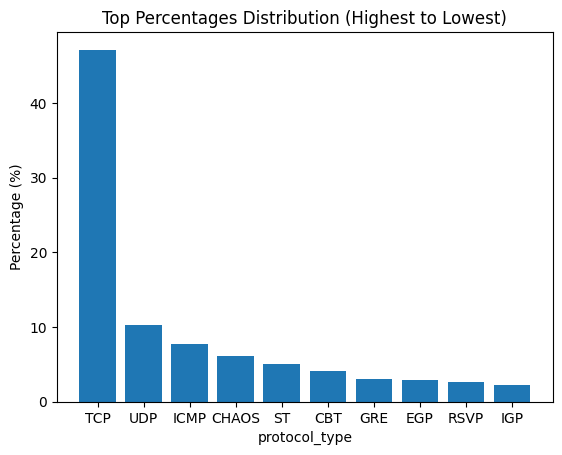

Top Percentages (from Highest to Lowest):
protocol_type
TCP                   47.130530
UDP                   10.242889
ICMP                   7.736383
CHAOS                  6.051682
ST                     5.001598
CBT                    4.070219
GRE                    2.958499
EGP                    2.919691
RSVP                   2.563576
IGP                    2.271378
BBN-RCC-MON            1.435876
XNET                   1.050084
PUP                    1.031822
NVP-II                 1.018125
ARGUS (deprecated)     0.856047
IDRP                   0.849199
HOPOPT                 0.652879
EMCON                  0.641465
IPv4                   0.470255
IPv6-Frag              0.264804
IGMP                   0.216865
IPv6-Route             0.152947
GGP                    0.125554
SDRP                   0.073049
IPv6                   0.036525
DDP                    0.029676
TP++                   0.025111
IL                     0.022828
IDPR-CMTP              0.020545
XTP             

In [9]:
# Calculate percentages for each unique value
value_counts = df2['protocol_type'].value_counts(normalize=True) * 100

# Sort percentages from highest to lowest
sorted_percentages = value_counts.sort_values(ascending=False)

# Get top 10 percentages (or fewer if there are less than unique values)
top_percentages = sorted_percentages.head(10)

# Plot histogram for the top values sorted by percentage
plt.bar(top_percentages.index, top_percentages.values)
plt.title("Top Percentages Distribution (Highest to Lowest)")
plt.xlabel("protocol_type")
plt.ylabel("Percentage (%)")
plt.xticks(top_percentages.index)  # Ensure x-axis labels show only top values
plt.show()

# Print the top sorted percentages
print("Top Percentages (from Highest to Lowest):")
print(sorted_percentages)

In [10]:
default_drop_col = ['protocol_type']

In [11]:
df2_filtered = df2.drop(default_drop_col,axis=1)
# filter out columns with uniform distribution(always the same value)
skewness = df2_filtered.skew()
print(skewness)

flow_duration       48.161713
header_length        6.005412
duration             3.443384
rate                22.860738
srate               22.860738
drate              125.187242
fin_flag_number      4.151039
syn_flag_number      1.897748
rst_flag_number      3.582156
psh_flag_number      3.702496
ack_flag_number      1.032078
ece_flag_number      0.000000
cwr_flag_number      0.000000
ack_count            3.492269
syn_count            1.843452
fin_count            6.774566
urg_count           11.364343
rst_count            7.193893
http                 3.236930
https                2.271577
dns                 31.153397
telnet               0.000000
smtp                 0.000000
ssh                 23.635893
irc                  0.000000
tcp                 -0.355304
udp                  1.679481
dhcp                 0.000000
arp                 28.169635
icmp                 2.957198
ipv                -24.956848
llc                -24.956848
tot_sum              3.237007
min       

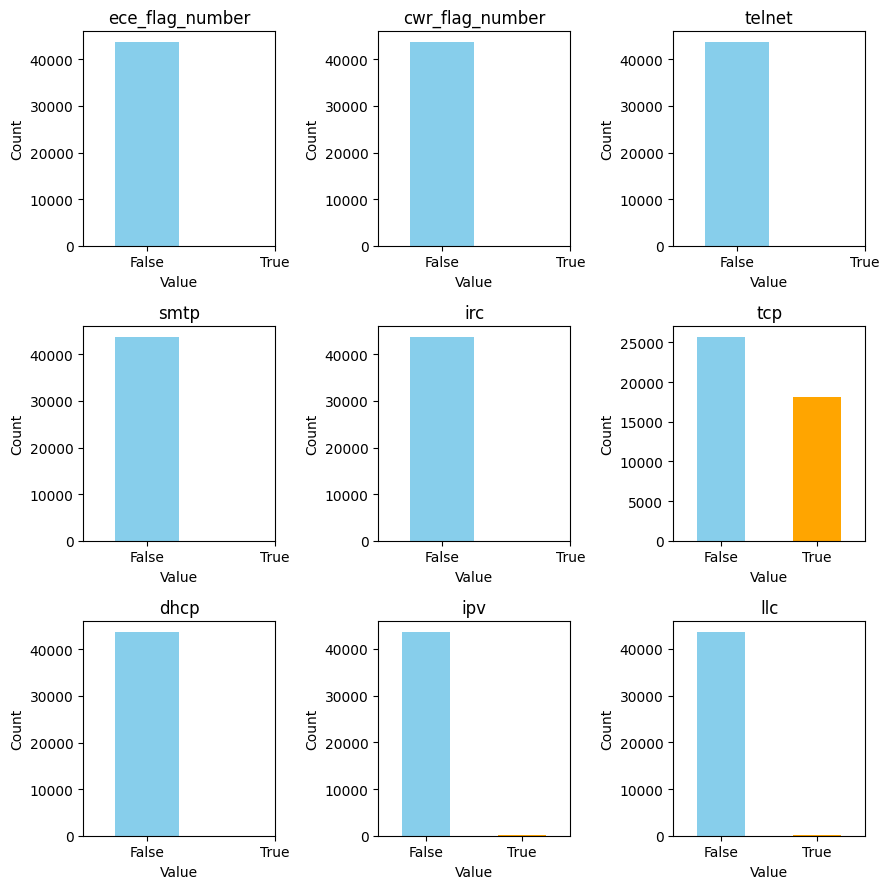

In [12]:
df2_ls = df2_filtered.loc[:,skewness<0.00001]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each column's histogram in the corresponding subplot
for i, column in enumerate(df2_ls.columns):
    # Count the occurrences of True and False
    value_counts = df2_ls[column].value_counts()
    # Plot the histogram
    value_counts.plot(kind='bar', color=['skyblue', 'orange'], ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [13]:
# delete zero viraince features(columns with single value, which doens't contain any info)
tbd_ls_cols = ['ece_flag_number','cwr_flag_number','telnet','smtp','irc','dhcp']

   flow_duration  header_length  rate  srate  drate  fin_count  urg_count  \
0       1.828260            171     1      1    0.0          0          0   
1       0.094752             60     2      2    0.0          0          0   
2      13.775582         583305   101    101    0.0          0         38   
3       2.488923        3754787  2722   2722    0.0          0          0   
4       1.264529         132935   113    113    0.0          0          8   
5       0.235886          67050   510    510    0.0          0          0   
6      18.061907            249   809    809    0.0          0          0   
7      15.880546         577591    80     80    0.0          0        112   
8       0.000000             53    11     11    0.0          0          0   
9       0.000000             54     1      1    0.0          0          1   

   rst_count    dns    ssh    arp   ipv   llc    covariance  
0          0  False  False  False  True  True  0.000000e+00  
1          0  False  False  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

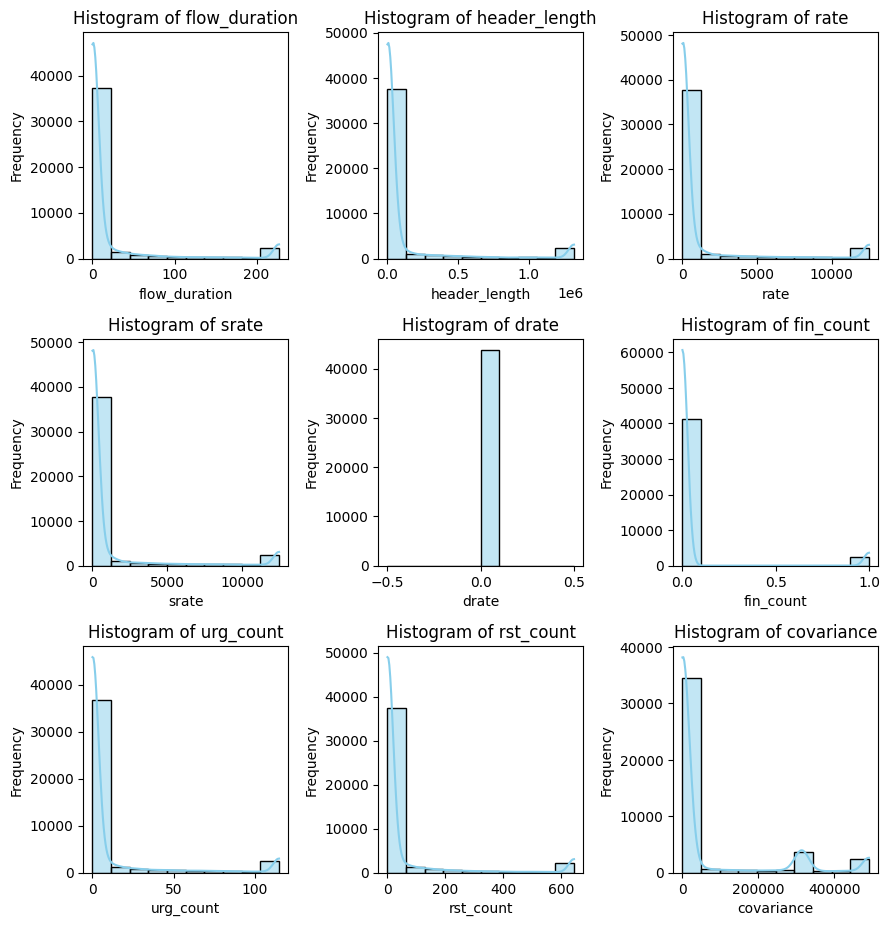

In [14]:
# analyze the colunmn with high abs skew values
df2_hs = df2_filtered.loc[:,abs(skewness)>5]

print(df2_hs.head(10))

# # Identify continuous columns (e.g., numeric columns)
continuous_columns = df2_hs.select_dtypes(include=['float64', 'int64']).columns

# Set up the plotting
plt.figure(figsize=(9, 12))

# # Loop through continuous columns and plot histograms
# for i, col in enumerate(continuous_columns, 1):
#     plt.subplot(4,3, i)  # 3x3 grid of subplots
#     sns.histplot(df2_hs[col], kde=True, bins=10, color='skyblue', edgecolor='black')  # histogram with KDE
#     plt.title(f'Histogram of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

# delete columns with too high skewness
from scipy.stats import mstats

df_winsorized = df2_hs[continuous_columns].apply(lambda x: mstats.winsorize(x, limits=[0.05, 0.05]))

print(df2_hs)
# Loop through continuous columns and plot histograms
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(4,3, i)  # 3x3 grid of subplots
    sns.histplot(df_winsorized[col], kde=True, bins=10, color='skyblue', edgecolor='black')  # histogram with KDE
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
hs_cols = ['srate','drate','flow_duration','header_length','rate','urg_count','rst_count','dns','ssh','arp','ipv','llc','max','covariance']
tbd_hs_cols = ['srate','drate'] 

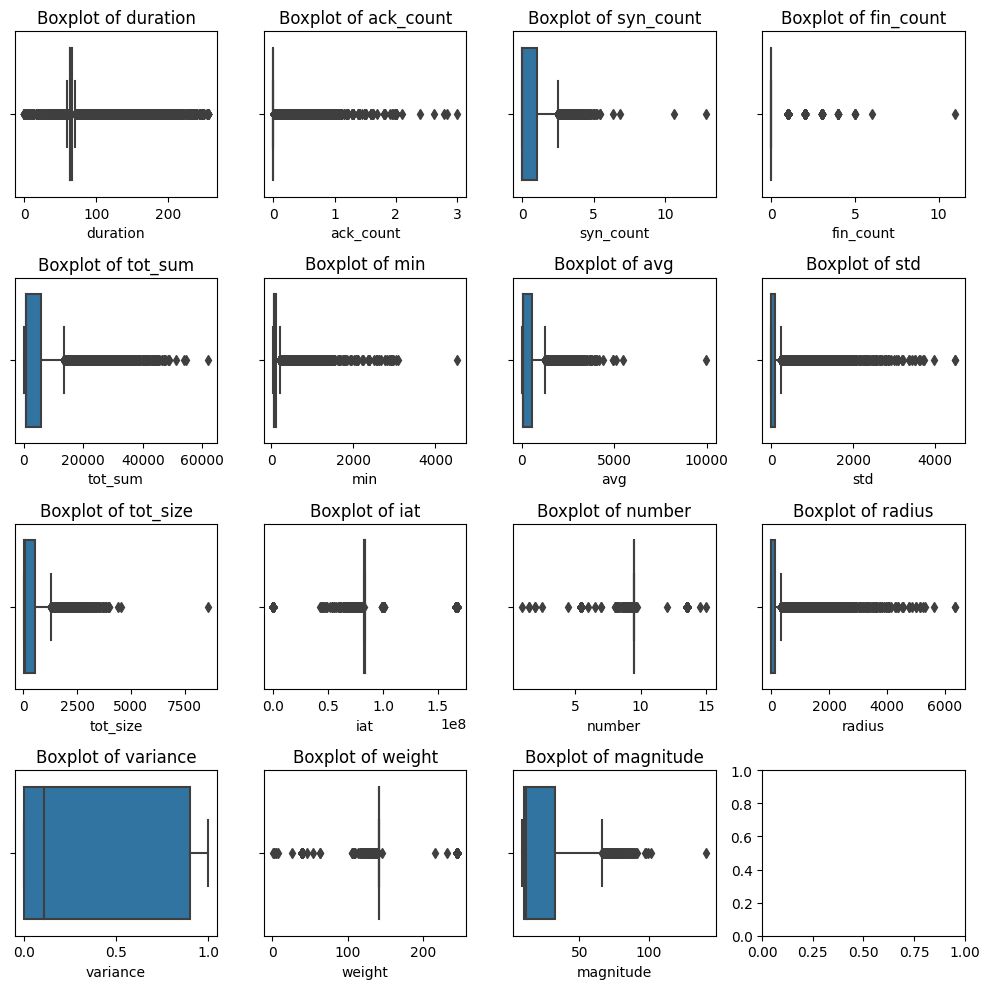

In [37]:
# show boxplot of parameter with comparatively normal distribution
df2_normal = df2_filtered.drop(tbd_ls_cols + hs_cols,axis =1)

continuous_columns = df2_normal.select_dtypes(include=['float64', 'int64']).columns


# Create a 3x3 grid for the boxplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the boxplot
for i, col in enumerate(continuous_columns):
    sns.boxplot(x=df2_normal[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [43]:
# Step 1: Correlation Analysis
corr_matrix = df2_normal.corr()

# Visualize the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")\
plt.title('Correlation Matrix')
plt.show()

SyntaxError: invalid syntax (171601776.py, line 7)

In [41]:
# Step 1: Compute the correlation matrix
corr_matrix = corr_matrix.abs()  # Use absolute values for correlations

# Step 2: Identify highly correlated pairs
threshold = 0.9  # Adjust threshold if needed
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Drop one feature from each highly correlated pair
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

print(f"Features to drop due to high correlation: {to_drop}")

df_reduced = df2_normal.drop(columns=to_drop)

# Step 4: Verify the resulting DataFrame
print(f"Remaining features: {df_reduced.columns.tolist()}")

Features to drop due to high correlation: ['avg', 'tot_size', 'number', 'radius', 'weight', 'magnitude']
Remaining features: ['duration', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'fin_count', 'http', 'https', 'tcp', 'udp', 'icmp', 'tot_sum', 'min', 'std', 'iat', 'variance', 'benign']


In [35]:
# Step 2: Dimension Reduction Using PCA
# Standardize the data (optional but recommended for PCA)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_reduced)


# Check the number of features in the reduced dataset
# n_features = df_reduced.shape[1]

# Dynamically set the number of components
# n_components = min(2, n_features)

# Apply PCA with the adjusted number of components
# pca = PCA(n_components=n_components)
pca = PCA(n_components=0.9)  # Retain 95% of variance

df_pca = pca.fit_transform(df_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by components: {explained_variance}")

# If PCA was performed with 1 component, skip visualization
if n_components == 2:
    # Visualize PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.7, c='blue')
    plt.title('PCA Result')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()
else:
    print(f"PCA reduced the data to {n_components} component(s); visualization skipped.")


Explained variance by components: [1.]


IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 800x600 with 0 Axes>

## Models Selection & Evaluation
|Model|Type|Advantage|
|--|--|--|
|LogisticRegression|Supervised  |Easy to implement, computational efficient|
|KNN               |Supervised  |widely-used for classification of known number(k) of clusters, can upgrade to outlier robust variant: DBSCAN|
|Random Forest     |unsupervised|Ensemble decision trees, robust to skewness of data|
|k-means           |Unsupervised|similar to KNN, can be used as comparison with KNN |
|Auto-encoder      |Unsupervised|Deep Learning model for abnormal detection|


In [ ]:
# Let's try sampling 400k datapoints

def split(df,df_name):
    if df_name == "df2":
        label = "benign"
# #         df = df2.sample(n=400000, random_state=42)
#         df = df2
    else:
        label = "label"
#         if df_name == "df8": df = df8.sample(n=400000, random_state=42)
#         else: df = df34.sample(n=400000, random_state=42)
    
    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]
    
    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test)
    
    # encoding for XGBoost
#     encoder = LabelEncoder()
#     encoded_y_train = encoder.fit_transform(y_train)
#     encoded_y_test = encoder.fit_transform(y_test)
    
    return scaled_X_train, scaled_X_test, y_train, y_test

In [ ]:
df2_normal = df2_filtered.drop(tbd_ls_cols + tbd_hs_cols,axis =1)
scaled_X_train, scaled_X_test, y_train, y_test = split(df2_normal,"df2")

In [ ]:
# creating dataframes to store result metrics
columns = ["Logistic Regression", "KNN", "Random Forest","k-Means" ]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

In [ ]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 8:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [ ]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, y_test, target_names, classes, model_name):
    pred = model.predict(scaled_X_test)
    
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])
    
#     if model_name == "XGBoost":
#         print(classification_report(y_test, pred, target_names = target_names, digits = 3))
        
#         if classes == 2 or classes == 8:
#             plt.figure(figsize = (4, 2), dpi = 300)
#             ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2), 
#                                    display_labels = target_names).plot()
#             plt.xticks(rotation=90);
#     else:
    print(classification_report(y_test, pred, digits = 3))

    if classes == 2 or classes == 8:
        plt.figure(figsize = (4, 2), dpi = 300)
        ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2), 
                               display_labels = target_names).plot()
        plt.xticks(rotation=90);

In [ ]:
# essential for df2
target_names = ["Attack", "Benign"]

In [ ]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 2, "Logistic Regression")

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 2, "KNN")

In [ ]:
# Weight-balanced
# rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest")

In [ ]:
# exporting and displaying the class 2 metrics
metrics_2.to_csv('metrics_2.csv', index=True)
metrics_2

### 8 Classes

In [ ]:
df8_filtered = df8.drop(default_drop_col,axis=1)
df8_normal = df8_filtered.drop(tbd_ls_cols + tbd_hs_cols,axis =1)

In [ ]:
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]
scaled_X_train, scaled_X_test, y_train, y_test = split(df8_normal, "df8")

In [ ]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 8, "Logistic Regression")

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 8, "KNN")

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest")

In [ ]:
# exporting and displaying the class 8 metrics
metrics_8.to_csv('metrics_8.csv', index=True)
metrics_8

### 34 Classes

In [ ]:
df34_filtered = df34.drop(default_drop_col,axis=1)
df34_normal = df34_filtered.drop(tbd_ls_cols + tbd_hs_cols,axis =1)

In [ ]:
scaled_X_train, scaled_X_test, y_train, y_test = split(df34_normal,"df34")
print(y_test.value_counts())
target_names = list(y_test.unique())

In [ ]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 34, "Logistic Regression")

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 34, "KNN")

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest")

In [ ]:
# exporting and displaying the class 34 metrics
metrics_34.to_csv('metrics_34.csv', index=True)
metrics_34

In [ ]:
# List of model names
model_names = ["Logistic Regression", "KNN", "Random Forest"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 8, 34]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "KNN": 'tab:red',
    # "WSVM": 'tab:brown',
    "XGBoost": 'tab:pink',
    "Random Forest": 'tab:olive',
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(12, 4), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")
        
        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)
        
        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=30)
    
    # Save the figure
    plt.savefig(f'{metric}_scores.png', bbox_inches='tight')
    
    plt.show()

### Autoencoder

See: "Quantized Autoencoders (QAE)/Final Versions/QAE.py"

In [ ]:
!pip install tensorflow_model_optimization


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import numpy as np
import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
import os


class QAE:
    """
    Creates a Quantized Autoencoder (QAE) for anomaly detection from a dataset composed of X_preprocessed and y.
    Note that the "y" series has no importance on its own: we only use it to make the train-test split,
    but in principle all your values in y should have the same label as you want anomaly detection,
    not classification.

    Last modification on the 8th of August 2024 by Alexandre Le Mercier.
    """
    def __init__(self, X_preprocessed, y, random_seed=5, test_size:float=0.3, first_layer:int=128,
                 verbose:bool=True, activation:str='relu', loss:str='mean_squared_error', optimizer:str='adam',
                 epochs:int=50, batch_size:int=32, shuffle:bool=True, figures_path:str="", name:str="autoencoder",
                 pruning_initial_sparsity:float=0.2, pruning_final_sparsity:float=0.8, pruning_begin_step:int=0,
                 pruning_end_step_divider:int=32*10, pruning_epochs:int=10, pruning_batch_size:int=32,
                 number_of_clusters:int=8, models_path:str="", cluster_epochs:int=10, cluster_batch_size:int=32,
                 use_regularization:bool=True, regularization_weights:float=0.001,threshold:float=None):

        self.F1_score = None
        self.recall = None
        self.precision = None
        self.accuracy = None
        self.confusion_matrix = None
        self.model_for_export = None
        self.history = None
        self.y_val = None
        self.y_train = None
        self.X_val = None
        self.X_train = None
        self.input_dim = None
        self.autoencoder = None
        self.pruning_end_step = None

        self.X_preprocessed = X_preprocessed
        self.y = y
        self.seed = random_seed
        self.test_size = test_size
        self.first_layer = first_layer
        self.verbose = verbose
        self.activation = activation
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.figures_path = figures_path
        self.name = name
        self.pruning_initial_sparsity = pruning_initial_sparsity
        self.pruning_final_sparsity = pruning_final_sparsity
        self.pruning_begin_step = pruning_begin_step
        self.pruning_end_step_divider = pruning_end_step_divider
        self.pruning_epochs = pruning_epochs
        self.pruning_batch_size = pruning_batch_size
        self.number_of_clusters = number_of_clusters
        self.models_path = models_path
        self.cluster_epochs = cluster_epochs
        self.cluster_batch_size = cluster_batch_size
        self.use_regularization = use_regularization
        self.regularization_weights = regularization_weights
        self.threshold = threshold

        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)

        #assert tf.__version__ == "2.13.0", 'TensorFlow 2.13 required for compatibility with tfmot 0.8.0.'
        assert self.first_layer % 8 == 0, 'The specified layer number is not dividable by 8.'

        self.verbose_message(f"QAE INFO: Bottleneck layer will be made of {self.first_layer//8} neurons.")

        self.split_data()
        self.create_autoencoder_model()
        self.compile_autoencoder()

        self.verbose_message("QAE model successfully created. Execute self.train_autoencoder() when ready.")

    def split_data(self):
        self.X_train, self.X_val, _, _ = train_test_split(self.X_preprocessed,
                                                          self.y, test_size=self.test_size,
                                                          random_state=self.seed)
        self.input_dim = self.X_train.shape[1]
        self.pruning_end_step =  len(self.X_train) // self.pruning_end_step_divider

    def create_autoencoder_model(self):
        # Function to optionally add regularizer
        def add_dense_layer(units):
            return layers.Dense(units, activation=self.activation,
                                kernel_regularizer=regularizers.l2(self.regularization_weights) if self.use_regularization else None)

        layers_list = [
            add_dense_layer(self.first_layer),
            add_dense_layer(self.first_layer // 2),
            add_dense_layer(self.first_layer // 4),
            add_dense_layer(self.first_layer // 8),
            add_dense_layer(self.first_layer // 4),
            add_dense_layer(self.first_layer // 2),
            add_dense_layer(self.first_layer),
            layers.Dense(self.input_dim, activation='sigmoid')
        ]

        self.autoencoder = Sequential(layers_list)
        self.autoencoder.build(input_shape=(None, self.input_dim))

    def compile_autoencoder(self):
        self.autoencoder.compile(optimizer=self.optimizer, loss=self.loss)
        if self.verbose:
            self.autoencoder.summary()

    def train_autoencoder(self):
        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                                            epochs=self.epochs,
                                            batch_size=self.batch_size,
                                            shuffle=self.shuffle,
                                            verbose=self.verbose,
                                            validation_data=(self.X_val, self.X_val))
        if self.verbose:
            self.plot_learning_curves()
        self.save_model(self.autoencoder, f"{self.name}_model")
        self.model_for_export = self.autoencoder
        self.verbose_message("QAE model successfully trained. Execute self.quantize_autoencoder()"
                             " or self.prune_and_cluster_autoencoder() when ready.")

    def plot_learning_curves(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Learning Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(self.figures_path + "QAE_learning_curves.png")
        plt.show()


    def representative_data_gen(self):
        for input_value in tf.data.Dataset.from_tensor_slices(self.X_train).batch(1).take(100):
            yield [tf.cast(input_value, tf.float32)]

    def quantize_parameters_and_activation_functions(self, model, name=None):
        if name is None:
            name = f"{self.name}_int_quant_model"
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = self.representative_data_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        tflite_int_quant_model = converter.convert()
        self.save_model(tflite_int_quant_model, name, '.tflite')

    def quantize_autoencoder(self):
        converter = tf.lite.TFLiteConverter.from_keras_model(self.autoencoder)
        tflite_model = converter.convert()
        self.save_model(tflite_model, f'{self.name}_model', '.tflite')
        self.quantize_parameters_and_activation_functions(self.autoencoder)

    def prune_and_cluster_autoencoder(self):
        self.prune_autoencoder()
        self.cluster_autoencoder()

    def prune_autoencoder(self, quant=True):
        pruning_params = {
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=self.pruning_initial_sparsity,
                final_sparsity=self.pruning_final_sparsity,
                begin_step=self.pruning_begin_step,
                end_step=self.pruning_end_step
            )
        }
        config = self.autoencoder.get_config()
        weights = self.autoencoder.get_weights()
        self.autoencoder = keras.models.Sequential.from_config(config)
        self.autoencoder.set_weights(weights)
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(self.autoencoder, **pruning_params)
        pruned_model.compile(optimizer=self.optimizer, loss=self.loss)
        callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
        pruned_model.fit(self.X_train, self.X_train,
                         epochs=self.pruning_epochs,
                         batch_size=self.pruning_batch_size,
                         validation_data=(self.X_val, self.X_val),
                         verbose=self.verbose,
                         callbacks=callbacks)
        self.model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
        self.save_model(self.model_for_export, f'pruned_{self.name}_model')
        if quant is True:
            self.quantize_parameters_and_activation_functions(self.model_for_export, f"{self.name}_pruned_model")
        else:
            self.save_model(self.model_for_export, f"{self.name}_pruned_model", '.keras')

    def cluster_autoencoder(self, quant=True, use_pruned_model=False):
        clustering_params = {
            'number_of_clusters': self.number_of_clusters,
            'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS
        }
        if use_pruned_model:
            clustered_model = tfmot.clustering.keras.cluster_weights(self.model_for_export, **clustering_params)
        else:
            clustered_model = tfmot.clustering.keras.cluster_weights(self.autoencoder, **clustering_params)
        clustered_model.compile(optimizer='adam', loss='mean_squared_error')
        clustered_model.fit(self.X_train, self.X_train,
                            epochs=self.cluster_epochs,
                            batch_size=self.cluster_batch_size,
                            validation_data=(self.X_val, self.X_val))
        final_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)
        self.save_model(final_clustered_model, f'clustered_{self.name}_model')
        if quant:
            self.quantize_parameters_and_activation_functions(final_clustered_model, f'{self.name}_clustered_model')
        else:
            self.save_model(final_clustered_model, f"{self.name}_clustered_model", '.keras')

    def test_on_validation_set(self, path_to_model, X_benign_val_preprocessed=None, X_anomaly_preprocessed=None,
                               percentage_false_negatives: float = 0.05, automatic_threshold: bool = False, silence=False,
                               manual_threshold=None, anomaly_if="higher"):
        # Load the model
        autoencoder = tf.keras.models.load_model(path_to_model)

        # Plotting function remains unchanged
        def plot_reconstruction_error_boxplot(reconstruction_error, threshold, title):
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=reconstruction_error, color='blue')
            plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold}')
            plt.title(title)
            plt.xlabel('Reconstruction Error')
            plt.legend()
            plt.xlim([0, np.percentile(reconstruction_error, 99)])
            plt.show()

        # Calculate the threshold based on the training data
        X_benign_train_reconstructed = autoencoder.predict(self.X_preprocessed)
        reconstruction_error_train = tf.keras.losses.mean_squared_error(self.X_preprocessed, X_benign_train_reconstructed).numpy()

        if self.threshold is not None:
            threshold = self.threshold
        elif automatic_threshold:
            threshold = np.mean(reconstruction_error_train) + np.std(reconstruction_error_train)
        elif manual_threshold is not None:
            threshold = manual_threshold
        else:
            threshold = np.percentile(reconstruction_error_train, 100 * (1.0 - percentage_false_negatives))

        self.threshold = threshold

        # Plot boxplot for training data
        if not silence:
            plot_reconstruction_error_boxplot(reconstruction_error_train, threshold, title='RE Boxplot on Training Data')

        if X_anomaly_preprocessed is None and X_benign_val_preprocessed is None:
            sets = []
        elif X_anomaly_preprocessed is None:
            sets = [(X_benign_val_preprocessed, 'Validation Benign Data')]
        else:
            sets = [(X_anomaly_preprocessed, 'Malicious Data'), (X_benign_val_preprocessed, 'Validation Benign Data')]

        # Initialize confusion matrix components
        TP = FP = TN = FN = 0

        for X, description in sets:
            X_reconstructed = autoencoder.predict(X)
            reconstruction_error = tf.keras.losses.mean_squared_error(X, X_reconstructed).numpy()

            # Plot boxplot for validation sets
            if not silence:
                plot_reconstruction_error_boxplot(reconstruction_error, threshold, title=f'RE Boxplot on {description}')

            # Check for anomalies based on reconstruction error
            if anomaly_if == "higher":
                anomalies = reconstruction_error > threshold
            elif anomaly_if == "lower":
                anomalies = reconstruction_error < threshold
            else:
                print("'anomaly_if' must be either 'higher' or 'lower'.")
                return

            # Calculate TP, FP, TN, FN based on description
            if description == 'Validation Benign Data':
                TN += np.sum(~anomalies)  # True Negatives: Benign correctly identified
                FP += np.sum(anomalies)   # False Positives: Benign incorrectly identified as anomaly
            elif description == 'Malicious Data':
                TP += np.sum(anomalies)   # True Positives: Malicious correctly identified as anomaly
                FN += np.sum(~anomalies)  # False Negatives: Malicious incorrectly identified as benign

        if X_anomaly_preprocessed is not None and X_benign_val_preprocessed is not None:
            self.accuracy = (TP + TN) / (TP + FP + TN + FN)
            self.precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            self.recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            self.F1_score = 2 * (self.precision * self.recall) / (self.precision + self.recall) if (self.precision + self.recall) > 0 else 0
            self.confusion_matrix = [
                [TN, FP],
                [FN, TP]
            ]

            if not silence:
                print("Accuracy:", self.accuracy)
                print("Precision:", self.precision)
                print("Recall:", self.recall)
                print("F1 score:", self.F1_score)
                print("Confusion matrix:", self.confusion_matrix)


        # Plotting distribution of reconstruction errors
        """
        if not silence:
            plt.figure(figsize=(12,8))
            sns.set(font_scale=2)
            sns.set_style("white")
            sns.histplot(reconstruction_error_train, bins=50, kde=True, color='grey', linewidth=3, label='Train Loss')
            plt.axvline(x=np.mean(reconstruction_error_train), color='g', linestyle='--', linewidth=3)
            plt.text(np.mean(reconstruction_error_train), 200, "Normal Mean", horizontalalignment='center', 
                     size='small', color='black', weight='semibold')
            plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
            plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
                     size='small', color='blue', weight='semibold')

            for i, loss in enumerate(test_loss):
                color = 'red' if i == 0 else 'blue'
                label = 'Test Loss' if i == 0 else 'Validation Loss'
                sns.histplot(loss, bins=50, kde=True, color=color, linewidth=3, label=label)
                plt.axvline(x=np.mean(loss), color='g', linestyle='--', linewidth=3)
                plt.text(np.mean(loss), 200, f"{label} Mean", horizontalalignment='center', 
                         size='small', color='black', weight='semibold')
                plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)

            plt.xlabel("Loss")
            plt.ylabel("Number of Examples")
            plt.legend()
            sns.despine()
            plt.show()
        """

    def verbose_message(self, message):
        if self.verbose:
            print(message)

    def save_model(self, model, name, ext='.keras'):
        if ext == ".keras" or ext == ".h5":
            model.save(self.models_path + name + ext)
        elif ext == ".tflite":
            with open(self.models_path + name + ext, 'wb') as f:
                f.write(model)
        self.verbose_message(f"Model {self.models_path + name + ext} saved. "
                             f"Size: {os.path.getsize(self.models_path + name + ext) / 1024} KB")

In [ ]:
qae_example = QAE(benign_df_tr, pd.Series(["is_benign"]*benign_df_tr.shape[0]))

In [ ]:
#qae_example.train_autoencoder()

In [ ]:
!mkdir Models

In [ ]:
# Choosing the threshold visually
best_params = {
    'name': "best_optuna_ben050.0_mal000.1_qae",
    'first_layer': 288, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 112, 'regularization_weights': 0.004035483817578062,
    'epochs': 20,
    'use_regularization': True
}
params = {
        'name': "Models/final_opt_qae",
        'first_layer': best_params['first_layer'],
        'activation': best_params['activation'],
        'optimizer': best_params['optimizer'],
        'batch_size': best_params['batch_size'],
        'regularization_weights': best_params['regularization_weights'],
        'epochs': 20,
        'use_regularization': True
}

#lim = 1000000
qae = QAE(benign_df_tr, pd.Series(["is_benign"]*benign_df_tr.shape[0]), **params)
qae.threshold=150
qae.train_autoencoder()

In [ ]:
qae.save_model(qae.autoencoder, "final_opt_qae")

In [ ]:
qae.threshold = 150
qae.test_on_validation_set("/kaggle/working/final_opt_qae.keras",
                                   benign_df_val,
                                   DDoS_df,
                                   silence=False,
                                   anomaly_if="lower"                   
                          )

In [ ]:
training_df, validation_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

training_df["is_benign"] = training_df["benign"]
training_df.drop("benign", axis=1, inplace=True)

validation_df["is_benign"] = validation_df["benign"]
validation_df.drop("benign", axis=1, inplace=True)

def preprocessing_pipeline(df):
    significant_features = ["variance", "duration", "https", "tcp", "tot_sum", "ack_flag_number"]
    features_to_scale_and_square = ["weight", "iat", "number"]
    scaler = StandardScaler()
    for feat in df.columns:
        if feat not in significant_features + features_to_scale_and_square + ["is_benign"]:
            df.drop(feat, axis=1, inplace=True)
    for feat in features_to_scale_and_square:
        df[f"scaled_{feat}2"] = scaler.fit_transform(df[[feat]])**2
        if feat in df:
            df.drop(feat, axis=1, inplace=True)
        else:
            print(f"{feat} was not part of training_df.")

    for feat in significant_features:
        df[f"scaled_{feat}"] = scaler.fit_transform(df[[feat]])
        if feat in df:
            df.drop(feat, axis=1, inplace=True)
        else:
            print(f"{feat} was not part of training_df.")
            
    return df

            
val_df = preprocessing_pipeline(validation_df)
val_df.describe()

In [ ]:
import sklearn

# Classify samples based on the threshold
y_test = val_df["is_benign"]
y_pred = (val_df['scaled_weight2'] > best_threshold)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = sklearn.metrics.f1_score(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

## 7.4 Testing the Autoencoder Model

In [ ]:
"""
params = {
        'name': "final_opt_qae",
        'first_layer': best_params['first_layer'],
        'activation': best_params['activation'],
        'optimizer': best_params['optimizer'],
        'batch_size': best_params['batch_size'],
        'regularization_weights': best_params['regularization_weights'],
        'epochs': 20,
        'use_regularization': True
}

qae = QAE(DDoS_df_tr, pd.Series(["is_benign"]*benign_df_tr.shape[0]), **params)
qae.train_autoencoder()
"""


benign_df = val_df[val_df["is_benign"] == True]
benign_df.drop("is_benign", axis=1, inplace=True)
DDoS_df = val_df[val_df["is_benign"] == False]
DDoS_df.drop("is_benign", axis=1, inplace=True)

s = benign_df.shape[0]
s2 = DDoS_df.shape[0]

benign_df_tr, benign_df_val = benign_df[:int(s*0.9)], benign_df[int(s*0.9):]
DDoS_df_tr, DDoS_df_val = DDoS_df[:int(s2*0.9)], DDoS_df[int(s2*0.9):]
#qae.threshold = 25
qae.test_on_validation_set("/kaggle/working/final_opt_qae.keras",
                                   benign_df,
                                   DDoS_df,
                                   silence=False,
                                   manual_threshold=150,
                                   anomaly_if="lower"
                          )

## Save the Models

In [ ]:
def pickle_save(model, name):
    model_filename = name + '.pkl'
    with open(name, 'wb') as model_file:
        pickle.dump(model, model_file)

    print(f"Model saved to {name}")

pickle_save(model, "Models/random_forest_DoS_model")
pickle_save(lin_model, "Models/linear_DoS_model")
pickle_save(qae, "Models/autoencoder_DoS_model")

# Efficient Intrution Detection
In real-world application, 

## Evaluation of Models Trained on Smaller Data Subsets Applied to Larger Datasets

## Potential integration with IPS(Intrusion Prevention System)
Feature Importance Study 

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import recall_score, precision_score
import pickle

# Custom classifier for threshold-based classification
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def fit(self, X, y=None):
        # No fitting process needed for this threshold-based classifier
        return self

    def predict(self, X):
        # Predict based on the threshold
        return (X['scaled_Weight2'] > self.threshold).astype(int)

    def predict_proba(self, X):
        # Return probabilities (1.0 or 0.0) for simplicity
        probas = (X['scaled_Weight2'] > self.threshold).astype(float)
        return pd.DataFrame({'class_0': 1 - probas, 'class_1': probas}).values

# Create and fit the ThresholdClassifier
tmodel = ThresholdClassifier(threshold=best_threshold)
tmodel.fit(tr_sv_thr)

pickle_save(tmodel, "Models/threshold_DoS_model")

In [ ]:
threshold=best_threshold # found with optuna

# Classify samples based on the threshold
predictions = ((training_df['ack_flag_number'] == 1) | (training_df['scaled_weight2'] > threshold)).astype(int)

# Calculate recall and precision
recall = recall_score(training_df['is_benign'], predictions)
precision = precision_score(training_df['is_benign'], predictions)

print("Recall (benign traffic misclassified as attack):", recall)
print("Precision (malicious traffic misclassified as benign):", precision)

tr_sv_thr = training_df

# Identify misclassified samples
misclassified = training_df[predictions != training_df['is_benign']]
misclassified.shape